# Análisis Exploratorio de Datos: Exoplanetas y Estrellas Anfitrionas

Este cuaderno reproduce el Análisis Exploratorio de Datos (EDA) realizado sobre el conjunto de datos de exoplanetas extraído de bases de datos públicas. El objetivo es investigar cómo las propiedades de las estrellas influyen en las de sus exoplanetas.

## 1. Carga y Preprocesamiento de Datos

Cargamos el archivo CSV, examinamos su estructura y realizamos la preparación necesaria para el análisis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leer el conjunto de datos
data_path = 'Data/exoplaneteu_catalog-1.csv'
df = pd.read_csv(data_path, sep=';', low_memory=False)

print('Dimensiones del conjunto de datos:', df.shape)
df.head()

Dimensiones del conjunto de datos: (7782, 98)


,name,discovered,updated,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,...,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names,planet_status,publication,mass_measurement_type,radius_measurement_type
0,TOI-2844 b,2024,2025-01-20,54.0000,5.30000,4.90000,NaN,NaN,NaN,0.7750,...,6910.0,210.0,210.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
1,TOI-286 c,2024,2024-06-11,0.0117,0.00698,0.00698,NaN,NaN,NaN,0.1677,...,5132.0,12.0,12.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
2,TOI-2986 b,2025,2025-07-03,0.3040,0.08600,0.06700,NaN,NaN,NaN,0.8290,...,5906.0,69.0,66.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
3,TOI-3023 b,2022,2022-10-31,0.6200,0.10000,0.10000,NaN,NaN,NaN,1.4660,...,5760.0,88.0,88.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
4,TOI-3321 Ab,2024,2025-02-11,0.5540,0.07600,0.07600,NaN,NaN,NaN,1.3900,...,5850.0,140.0,140.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit


### 1.1 Ingeniería de Características

Derivamos columnas adicionales:

- `spec_class`: clase espectral simplificada obtenida de la primera letra de la columna `star_sp_type`.
- `is_giant`: indicador booleano de si un planeta se considera gigante (masa ≥ 0,3 $M_{Jup}$ o radio ≥ 0,6 $R_{Jup}$).

In [2]:
# Derivar clase espectral
df['spec_class'] = df['star_sp_type'].astype(str).str[0].str.upper()
df['spec_class'] = df['spec_class'].where(df['spec_class'].isin(list('OBAFGKM')), 'Other')

# Función para clasificar planetas gigantes
def es_gigante(fila):
    masa = fila['mass']
    radio = fila['radius']
    return (pd.notnull(masa) and masa >= 0.3) or (pd.notnull(radio) and radio >= 0.6)

# Aplicar clasificación
df['is_giant'] = df.apply(es_gigante, axis=1)

# Vista previa de columnas derivadas
df[['name','spec_class','mass','radius','is_giant']].head()

,name,spec_class,mass,radius,is_giant
0,TOI-2844 b,Other,54.0000,0.7750,True
1,TOI-286 c,K,0.0117,0.1677,False
2,TOI-2986 b,G,0.3040,0.8290,True
3,TOI-3023 b,Other,0.6200,1.4660,True
4,TOI-3321 Ab,G,0.5540,1.3900,True


## 2. Visión General de los Datos

Examinamos patrones de valores faltantes, entradas duplicadas y estadísticas básicas.

In [3]:
# Porcentaje de valores faltantes por columna
porc_faltantes = df.isnull().mean() * 100
porc_faltantes.sort_values(ascending=False).head(15)

hot_point_lon                 99.948599
star_magnetic_field           99.922899
geometric_albedo_error_min    99.794397
geometric_albedo_error_max    99.794397
geometric_albedo              99.781547
tzero_vr_error_max            99.408892
tzero_vr_error_min            99.408892
tzero_vr                      99.370342
tzero_tr_sec_error_max        99.331791
tzero_tr_sec_error_min        99.331791
tzero_tr_sec                  99.318941
log_g                         99.151889
star_detected_disc            98.535081
lambda_angle                  98.059625
lambda_angle_error_max        98.046775
dtype: float64

In [4]:
# Comprobación de duplicados por nombre de planeta
num_duplicados = df.duplicated(subset=['name']).sum()
print('Número de planetas duplicados:', num_duplicados)

Número de planetas duplicados: 0


In [5]:
# Estadísticas descriptivas para variables numéricas
cols_numericas = df.select_dtypes(include=[np.number]).columns
df[cols_numericas].describe().T

,count,mean,std,min,25%,50%,75%,max
discovered,7782.0,2015.663968,5.943856,1.988000e+03,2014.000000,2016.000,2020.00000,2025.00
mass,3663.0,14.940362,20.513623,1.420000e-09,0.131900,2.500,27.00000,78.27
mass_error_min,4042.0,2.502411,5.801482,0.000000e+00,0.012770,0.110,1.70000,56.10
mass_error_max,4032.0,3.516642,29.970306,-1.780000e+01,0.010987,0.104,1.89625,1635.00
mass_sini,1465.0,6.404820,12.462423,4.700000e-04,0.064800,1.210,5.58000,70.00
...,...,...,...,...,...,...,...,...
star_age_error_min,3425.0,0.375520,2.814897,-7.410000e+00,-1.770000,0.390,2.00000,86.00
star_age_error_max,3425.0,2.855920,10.053281,-2.600000e+00,0.850000,2.090,4.00000,500.00
star_teff,6205.0,5441.236702,1911.898047,1.300000e+03,4850.000000,5526.000,5902.00000,42065.00
star_teff_error_min,5864.0,121.275367,320.829194,-9.823110e+01,61.045000,100.000,133.00000,15000.00


## 3. Análisis Univariado

### 3.1 Distribución de Clases Espectrales de Estrellas

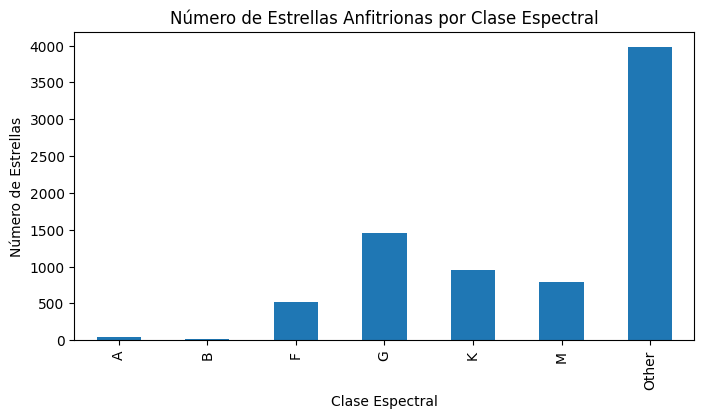

In [6]:
conteo_especies = df['spec_class'].value_counts().sort_index()

plt.figure(figsize=(8,4))
conteo_especies.plot(kind='bar')
plt.title('Número de Estrellas Anfitrionas por Clase Espectral')
plt.xlabel('Clase Espectral')
plt.ylabel('Número de Estrellas')
plt.show()

### 3.2 Radio Planetario por Clase Espectral

C:\Users\sebas\AppData\Local\Temp\ipykernel_37340\1305328728.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_radio, labels=clases)


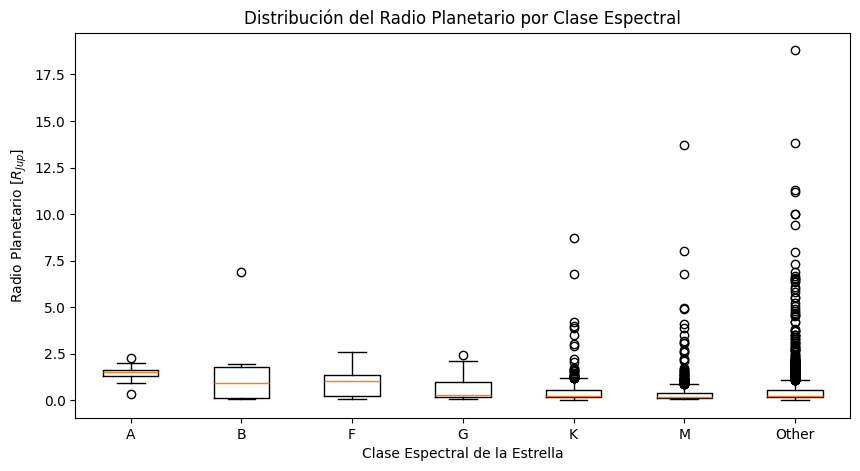

In [7]:
plt.figure(figsize=(10,5))
clases = conteo_especies.index
datos_radio = [df[df['spec_class']==c]['radius'].dropna() for c in clases]
plt.boxplot(datos_radio, labels=clases)
plt.title('Distribución del Radio Planetario por Clase Espectral')
plt.xlabel('Clase Espectral de la Estrella')
plt.ylabel('Radio Planetario [$R_{Jup}$]')
plt.show()

## 4. Análisis Bivariado

### 4.1 Masa Estelar vs Masa Planetaria

Exploramos la relación entre la masa de la estrella y la masa del planeta.

Coeficiente de correlación de Pearson: -0.048247833014850965


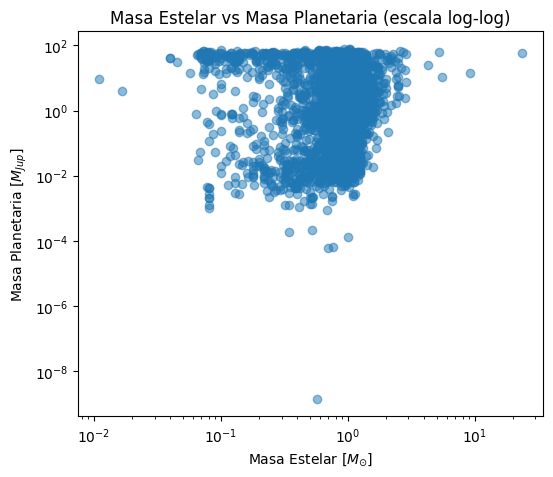

In [8]:
plt.figure(figsize=(6,5))
plt.scatter(df['star_mass'], df['mass'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Masa Estelar [$M_{\odot}$]')
plt.ylabel('Masa Planetaria [$M_{Jup}$]')
plt.title('Masa Estelar vs Masa Planetaria (escala log-log)')

# Calcular la correlación descartando NaN
valida = df[['star_mass','mass']].dropna()
correlacion = valida['star_mass'].corr(valida['mass'])
print('Coeficiente de correlación de Pearson:', correlacion)

plt.show()

### 4.2 Fracción de Planetas Gigantes por Clase Espectral

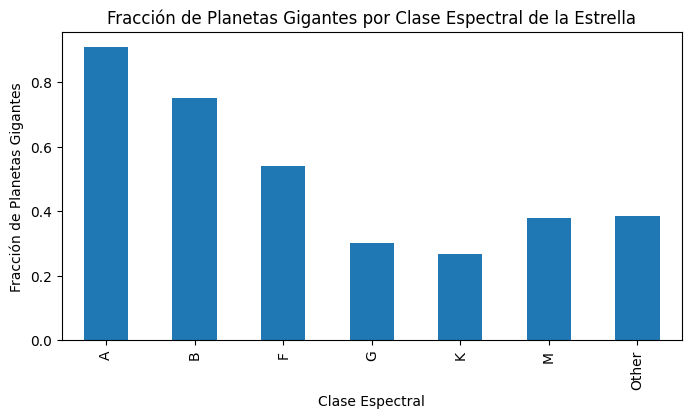

In [9]:
fraccion_gigantes = df.groupby('spec_class')['is_giant'].mean()

plt.figure(figsize=(8,4))
fraccion_gigantes.plot(kind='bar')
plt.title('Fracción de Planetas Gigantes por Clase Espectral de la Estrella')
plt.xlabel('Clase Espectral')
plt.ylabel('Fracción de Planetas Gigantes')
plt.show()

### 4.3 Número de Descubrimientos por Año

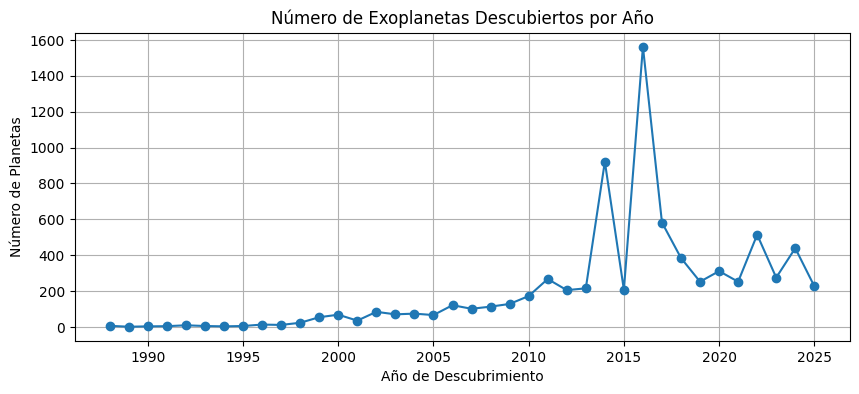

In [10]:
descubrimientos_anuales = df['discovered'].value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.plot(descubrimientos_anuales.index, descubrimientos_anuales.values, marker='o')
plt.title('Número de Exoplanetas Descubiertos por Año')
plt.xlabel('Año de Descubrimiento')
plt.ylabel('Número de Planetas')
plt.grid(True)
plt.show()

### 4.4 Mapa de Calor de Correlaciones

Examinamos las correlaciones entre un conjunto seleccionado de variables numéricas.

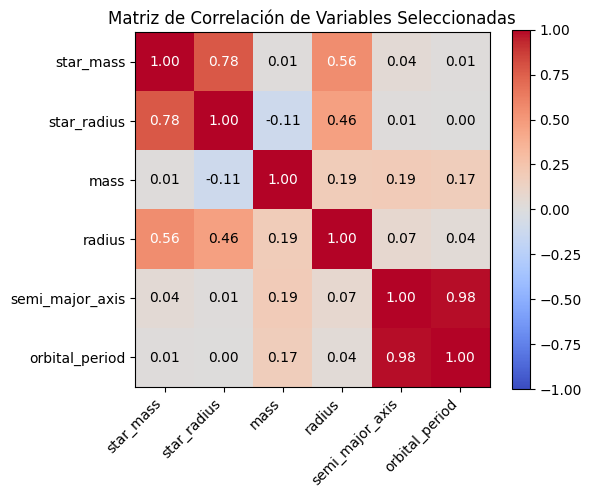

In [11]:
columnas_seleccionadas = ['star_mass','star_radius','mass','radius','semi_major_axis','orbital_period']
subconjunto = df[columnas_seleccionadas].copy().dropna()
matriz_cor = subconjunto.corr()

plt.figure(figsize=(6,5))
im = plt.imshow(matriz_cor, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(columnas_seleccionadas)), columnas_seleccionadas, rotation=45, ha='right')
plt.yticks(range(len(columnas_seleccionadas)), columnas_seleccionadas)

# Anotar con valores de correlación
for i in range(len(columnas_seleccionadas)):
    for j in range(len(columnas_seleccionadas)):
        valor = matriz_cor.iloc[i,j]
        plt.text(j, i, f'{valor:.2f}', ha='center', va='center',
                 color='white' if abs(valor) > 0.5 else 'black')

plt.title('Matriz de Correlación de Variables Seleccionadas')
plt.tight_layout()
plt.show()

## 5. Hallazgos y Conclusiones

- **Clases espectrales**: La mayoría de las estrellas anfitrionas pertenecen a las clases F, G, K y M; las clases A y B son poco frecuentes. La distribución está sesgada hacia estrellas de tipo solar (G y K).
- **Diferencias en tamaño planetario**: Los diagramas de cajas muestran que los planetas alrededor de estrellas F y G suelen tener radios mayores en promedio que los de estrellas K y M.
- **Correlación de masas**: El gráfico de dispersión de masa estelar vs masa planetaria no revela una correlación fuerte (coeficiente de Pearson próximo a 0), lo que sugiere que la masa estelar por sí sola no determina la masa planetaria.
- **Planetas gigantes**: La fracción de planetas gigantes es más alta en estrellas tipo F, mientras que en las clases K y G es menor. Las enanas M igualmente albergan una fracción significativa de gigantes.
- **Tendencias temporales**: Los descubrimientos de exoplanetas aumentaron con misiones como Kepler y se mantienen relativamente estables en años recientes.
- **Correlaciones**: Entre las variables seleccionadas, la masa planetaria se correlaciona moderadamente con el radio planetario; la masa estelar se correlaciona fuertemente con el radio estelar; y el semieje mayor se correlaciona con el período orbital, como era de esperar. Otras correlaciones son débiles.

### Limitaciones

- El conjunto de datos compila valores de diversas fuentes y puede mezclar mediciones inconsistentes, por lo que conviene actuar con precaución al sacar conclusiones causales.
- Existen numerosos valores faltantes, lo que puede sesgar los resultados.
- El trabajo futuro puede incluir imputación más rigurosa, ingeniería de características adicional y modelado predictivo.

---

Este cuaderno proporciona un flujo reproducible para realizar el EDA sobre el conjunto de datos de exoplanetas. Para repetir el análisis, asegúrate de que el archivo CSV esté disponible en la ruta especificada o ajusta la variable `data_path`.